In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelo Específico
from sklearn.ensemble import RandomForestClassifier

# Métricas
from sklearn.metrics import (classification_report, roc_auc_score, RocCurveDisplay,
                             ConfusionMatrixDisplay, precision_score, recall_score,
                             f1_score, confusion_matrix, precision_recall_curve)

# Balanceo
from imblearn.over_sampling import SMOTE

from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.tree import export_text

In [2]:
# CONFIGURACIÓN
SEED = 42
DATA_DIR = 'Data/' # Ajusta si tus archivos están en otra carpeta

# Umbral de corte inicial (Random Forest suele calibrar bien en 0.5, pero lo dejamos variable)
UMBRAL_CORTE = 0.5

pd.set_option('display.max_columns', None)

# Configuración Visual
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
# Archivos

MODELOCL = 'CL'
MODELOAR = 'DOMAR'
MODELOPE = 'DOMPE'
MODELOCO = 'DOMCO'
MODELOIN = 'INTER'


In [4]:
# Parámetros base para Random Forest
PARAMS_ESTATICOS = {
    'GENERAL': {
        'class_weight': 'balanced',
        'max_depth': 20,
        'min_samples_leaf': 4,
        'min_samples_split': 2,
        'n_estimators': 500
    },
    'CL':     {
        'class_weight': 'balanced',
        'max_depth': 12,
        'min_samples_leaf': 4,
        'min_samples_split': 2,
        'n_estimators': 400
    },
    'PE':     {
        'class_weight': 'balanced',
        'max_depth': 20,
        'min_samples_leaf': 1,
        'min_samples_split': 2,
        'n_estimators': 500
    },
    'CO':     {
        'class_weight': 'balanced',
        'max_depth': 12,
        'min_samples_leaf': 4,
        'min_samples_split': 2,
        'n_estimators': 500
    },
    'AR':     {
        'class_weight': 'balanced',
        'max_depth': 20,
        'min_samples_leaf': 1,
        'min_samples_split': 2,
        'n_estimators': 400
    }
}
PARAMS_OPTIMIZADOS = {
    'GENERAL': {'class_weight': 'balanced', 'n_estimators': 500, 'max_depth': 22, 'min_samples_split': 15, 'min_samples_leaf': 10},
    'CL': {'class_weight': 'balanced', 'n_estimators': 800, 'max_depth': 19, 'min_samples_split': 15, 'min_samples_leaf': 2},
    'PE': {'class_weight': 'balanced', 'n_estimators': 200, 'max_depth': 22, 'min_samples_split': 20, 'min_samples_leaf': 11},
    'CO': {'class_weight': 'balanced', 'n_estimators': 200, 'max_depth': 25, 'min_samples_split': 7, 'min_samples_leaf': 6},
    'AR': {'class_weight': 'balanced', 'n_estimators': 400, 'max_depth': 8, 'min_samples_split': 12, 'min_samples_leaf': 1}
}

In [5]:
def matriz_correlacion(pack_modelo, X, feature_names=None, top_n=37):
    """
    Genera la matriz de correlación de las variables más importantes y muestra
    explícitamente los nombres de las variables incluidas.
    Retorna: (corr_dataframe, lista_de_variables_incluidas)
    """
    model = pack_modelo['model']

    # 1. Obtener importancias (RandomForest)
    importancias = getattr(model, "feature_importances_", None)
    if importancias is None:
        raise ValueError("El modelo no tiene 'feature_importances_'. Asegúrate de pasar un RandomForest entrenado.")

    # 2. Crear DataFrame de features
    if isinstance(X, pd.DataFrame):
        df_X = X.copy()
    else:
        if feature_names is None:
            feature_names = [f"f_{i}" for i in range(X.shape[1])]
        df_X = pd.DataFrame(X, columns=feature_names)

    # 3. Selección top_n (o todas si top_n es None)
    if top_n is None or top_n >= df_X.shape[1]:
        cols_top = list(df_X.columns)
    else:
        # manejar posible desajuste de tamaño
        n_feats = min(len(importancias), df_X.shape[1])
        importancias = importancias[:n_feats]
        indices_top = np.argsort(importancias)[::-1][:top_n]
        cols_top = [df_X.columns[i] for i in indices_top]

    df_top = df_X[cols_top]

    # 4. Calcular Correlación (Pearson)
    corr = df_top.corr()

    # 5. Graficar
    plt.figure(figsize=(20, 12))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, square=True, cbar_kws={'shrink': .8}, annot_kws={'size':8})
    plt.title(f"Matriz de Correlación (Top {len(cols_top)} Variables)")
    plt.tight_layout()
    plt.show()

    return corr


In [6]:
def entrenar_rf_visual(X_train, X_test, y_train, y_test, nombre_modelo, params):

    print(f"PROCESANDO RANDOM FOREST: {nombre_modelo}")
    print(f"{'='*60}")

    # 1. Separar parámetros del modelo de los nuestros
    rf_params = {k: v for k, v in params.items() if k != 'usar_smote' and k != 'threshold'}

    # 2. Aplicar SMOTE (Balanceo)
    if params.get('usar_smote', False):
        print(f"-> Aplicando SMOTE (Balanceo Sintético)...")
        smote = SMOTE(random_state=SEED)
        X_train_final, y_train_final = smote.fit_resample(X_train, y_train)
    else:
        X_train_final, y_train_final = X_train, y_train

    # 3. Entrenar Modelo
    print(f"-> Entrenando bosque con {rf_params.get('n_estimators', '??')} árboles...")
    model = RandomForestClassifier(**rf_params)
    model.fit(X_train_final, y_train_final)

    # 4. Predicciones (Probabilidades)
    probs_test = model.predict_proba(X_test)[:, 1]

    # USAR UMBRAL FIJO (sin optimización automática)
    mejor_umbral = params.get('threshold', UMBRAL_CORTE)
    preds = (probs_test >= mejor_umbral).astype(int)

    # 5. Métricas y Reportes
    auc = roc_auc_score(y_test, probs_test)

    print(f"\nREPORTE FINAL ({nombre_modelo})")
    print(classification_report(y_test, preds, target_names=['Ocio', 'Trabajo']))
    print(f"AUC-ROC Score: {auc:.4f}")

    # 6. Gráficos
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    # Matriz de Confusión
    cm = confusion_matrix(y_test, preds)
    ConfusionMatrixDisplay(cm, display_labels=['Ocio', 'Trabajo']).plot(ax=ax[0], cmap='Greens')
    ax[0].set_title(f"Matriz de Confusión (Corte: {mejor_umbral:.2f})")
    ax[0].grid(False)

    # Curva ROC
    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax[1], name=nombre_modelo)
    ax[1].plot([0, 1], [0, 1], 'k--')
    ax[1].set_title("Curva ROC")

    plt.tight_layout()
    plt.show()

    return {'model': model}

In [7]:
def graficar_importancia_rf(pack_modelo, feature_names, top_n=20):

    model = pack_modelo['model']
    importancias = model.feature_importances_

    df_imp = pd.DataFrame({
        'Variable': feature_names,
        'Importancia': importancias
    }).sort_values('Importancia', ascending=False).head(top_n)

    vals = df_imp['Importancia'].values
    if vals.max() - vals.min() > 0:
        norm = (vals - vals.min()) / (vals.max() - vals.min())
    else:
        norm = np.zeros_like(vals)

    # Uso de la API recomendada: plt.get_cmap
    cmap = plt.get_cmap('viridis')
    colors = cmap(norm)

    fig, ax = plt.subplots(figsize=(16, 10))
    y_pos = np.arange(len(df_imp))
    bars = ax.barh(y_pos, df_imp['Importancia'].values, color=colors)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(df_imp['Variable'].values)
    ax.invert_yaxis()
    ax.set_xlabel("Importancia Relativa (0 a 1)")
    ax.set_title("Importancia de Variables (Random Forest - Gini)")

    # Intentar usar bar_label (más limpio). Si no existe, usar texto manual.
    try:
        ax.bar_label(bars, fmt='%.4f', padding=6)
    except Exception:
        max_width = df_imp['Importancia'].max() if len(df_imp) else 1.0
        x_offset = max_width * 0.01  # pequeño espacio a la derecha de la barra
        for bar in bars:
            w = bar.get_width()
            ax.text(w + x_offset, bar.get_y() + bar.get_height() / 2, f'{w:.3f}',
                    va='center', ha='left', fontsize=9)
    plt.tight_layout()
    plt.show()


PROCESANDO RANDOM FOREST: RF_General
-> Entrenando bosque con 500 árboles...

REPORTE FINAL (RF_General)
              precision    recall  f1-score   support

        Ocio       0.85      0.81      0.83      4551
     Trabajo       0.50      0.58      0.54      1540

    accuracy                           0.75      6091
   macro avg       0.68      0.69      0.68      6091
weighted avg       0.76      0.75      0.76      6091

AUC-ROC Score: 0.7894


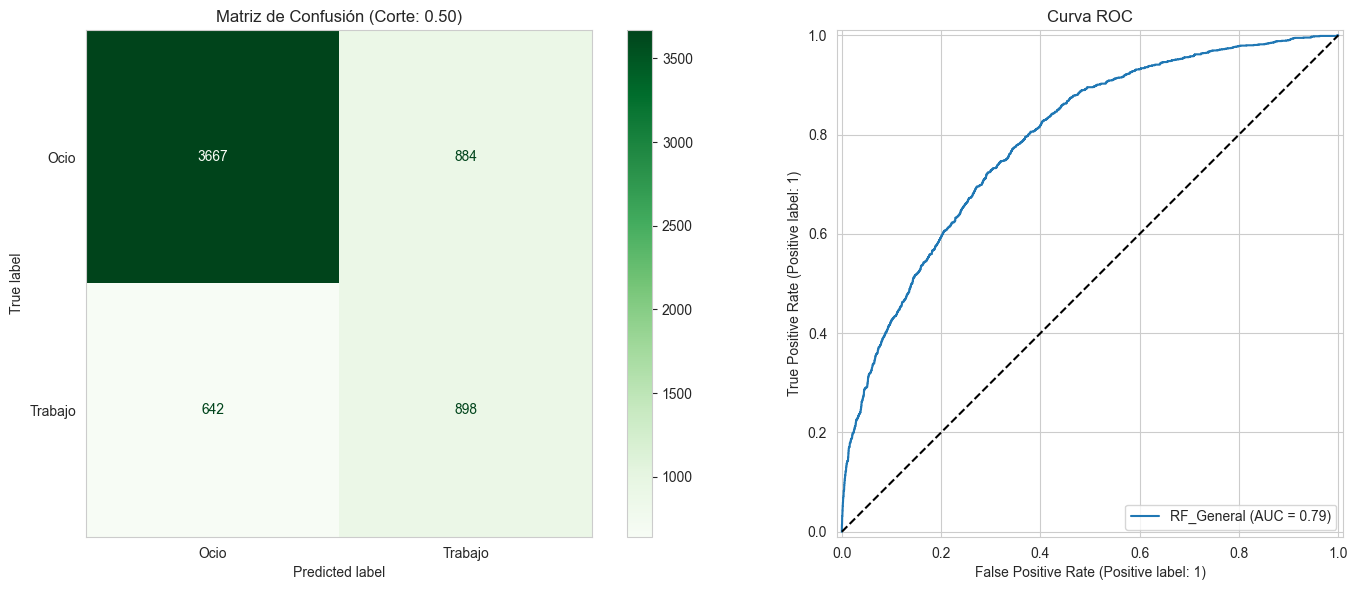

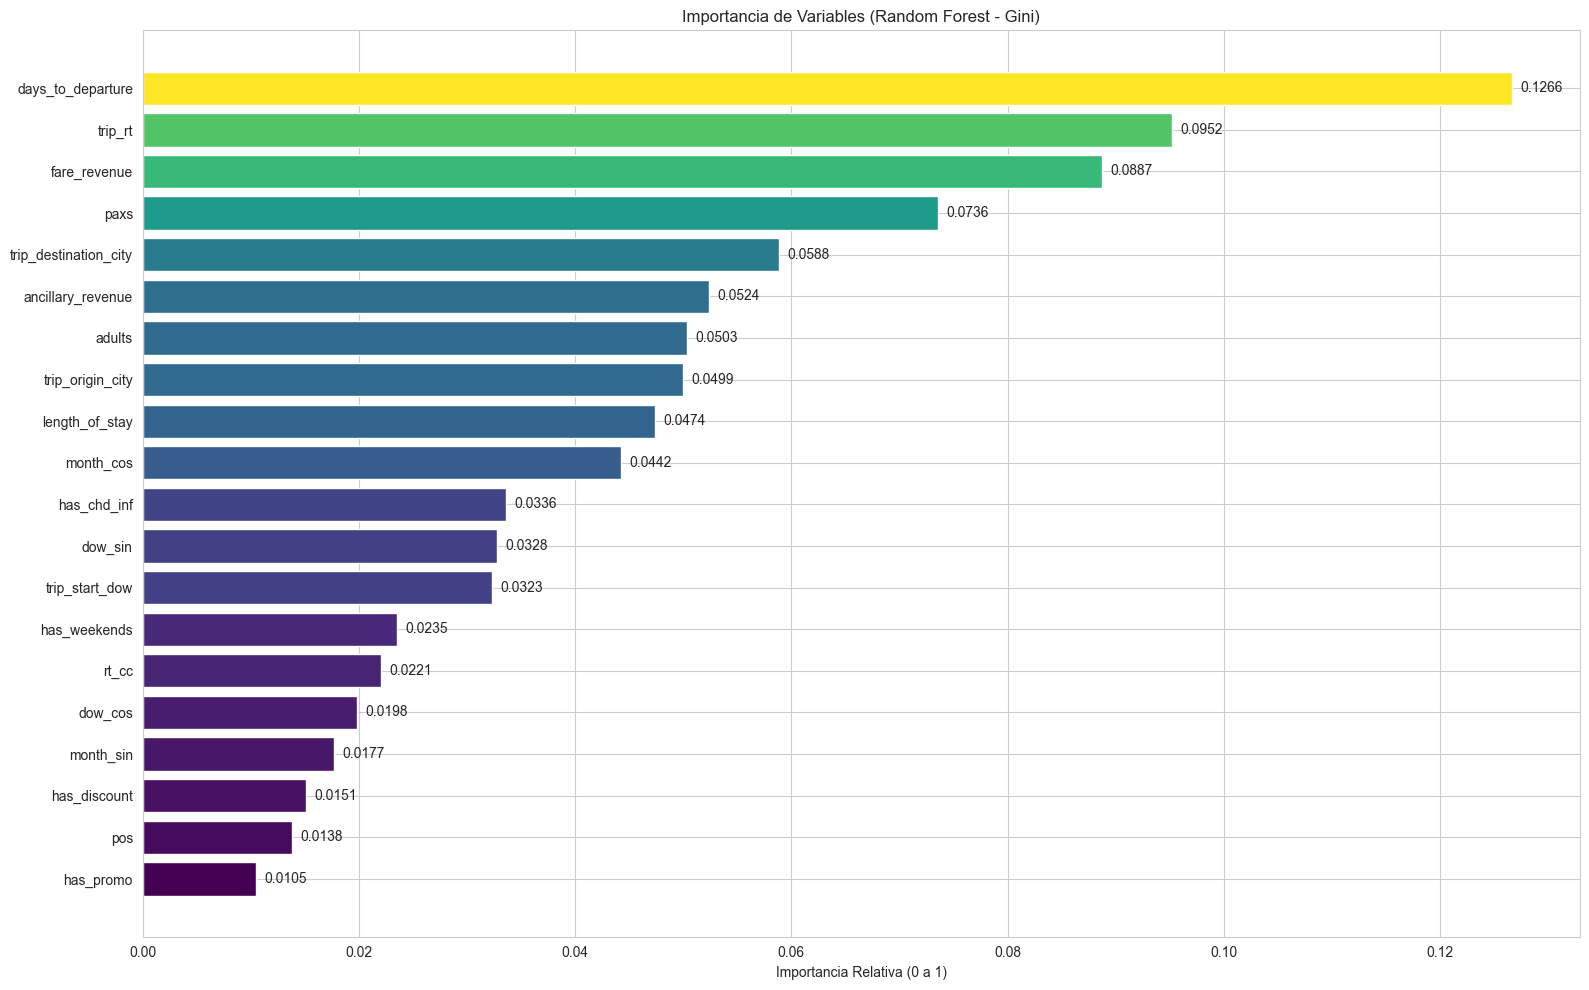

In [8]:
modelo = 'General'

X_train = pd.read_parquet(f'{DATA_DIR}X_train_{modelo}_encoded.parquet')# .drop(['days_to_departure'], axis=1)
X_test = pd.read_parquet(f'{DATA_DIR}X_test_{modelo}_encoded.parquet')# .drop(['days_to_departure'], axis=1)
y_train = pd.read_pickle(f'{DATA_DIR}y_train_{modelo}.pkl')
y_test = pd.read_pickle(f'{DATA_DIR}y_test_{modelo}.pkl')

# Entrenar
pack_rf_general = entrenar_rf_visual(
    X_train, X_test, y_train, y_test, 'RF_General', PARAMS_ESTATICOS['GENERAL']
)

# Graficar Importancia
graficar_importancia_rf(pack_rf_general, X_train.columns)

Cargando Chile...
PROCESANDO RANDOM FOREST: RF_Chile
-> Entrenando bosque con 400 árboles...

REPORTE FINAL (RF_Chile)
              precision    recall  f1-score   support

        Ocio       0.86      0.79      0.82       596
     Trabajo       0.66      0.75      0.70       317

    accuracy                           0.78       913
   macro avg       0.76      0.77      0.76       913
weighted avg       0.79      0.78      0.78       913

AUC-ROC Score: 0.8557


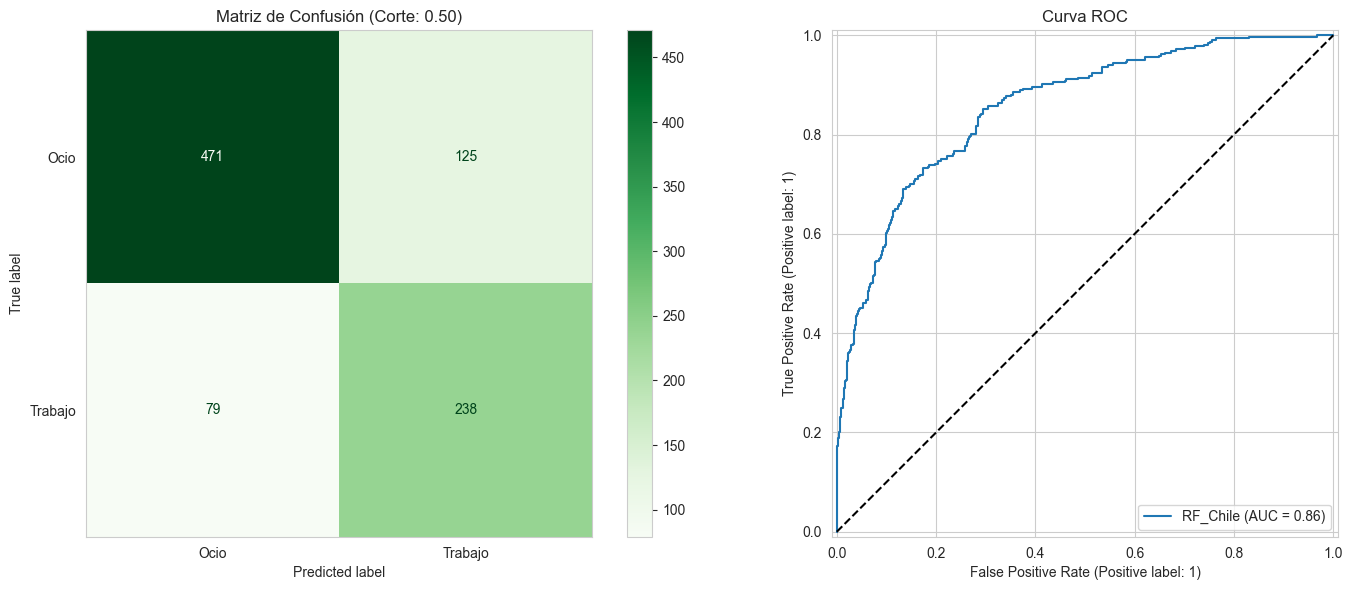

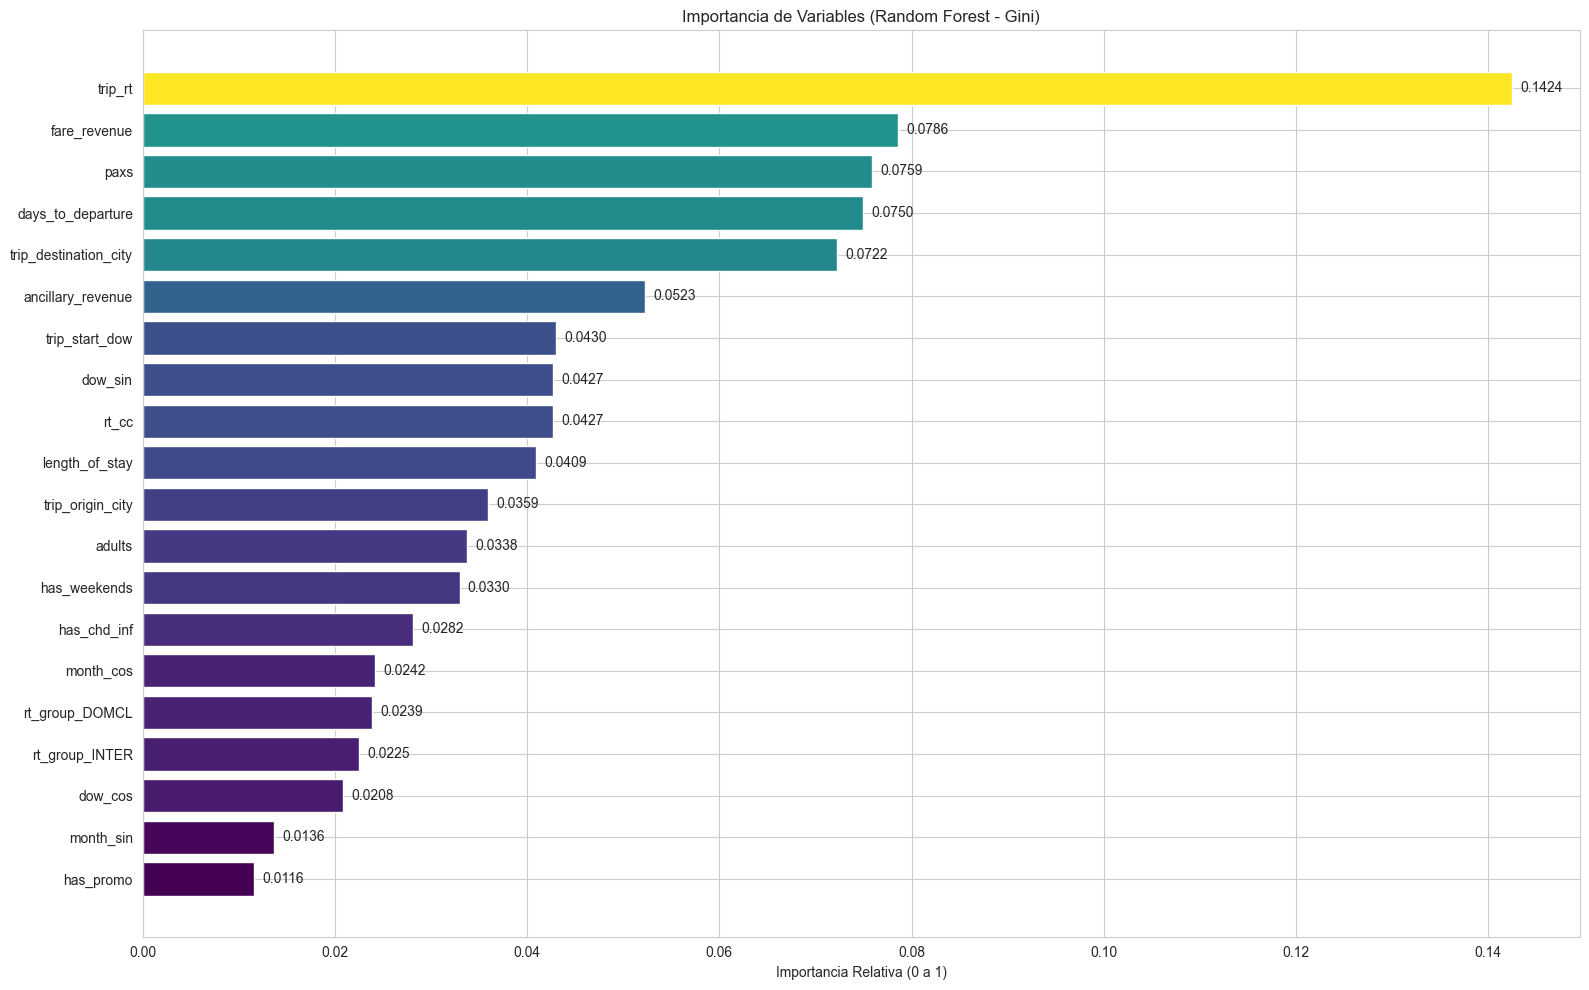

In [9]:
print("Cargando Chile...")
# Asegúrate que el nombre del archivo coincida con lo generado en el 01
X_train = pd.read_parquet(f'{DATA_DIR}X_train_{MODELOCL}_encoded.parquet')# .drop(['trip_rt'], axis=1)
X_test = pd.read_parquet(f'{DATA_DIR}X_test_{MODELOCL}_encoded.parquet')# .drop(['trip_rt'], axis=1)
y_train = pd.read_pickle(f'{DATA_DIR}y_train_{MODELOCL}.pkl')
y_test = pd.read_pickle(f'{DATA_DIR}y_test_{MODELOCL}.pkl')



pack_rf_cl = entrenar_rf_visual(
    X_train, X_test, y_train, y_test,
    "RF_Chile", PARAMS_ESTATICOS['CL']
)

graficar_importancia_rf(pack_rf_cl, X_train.columns)


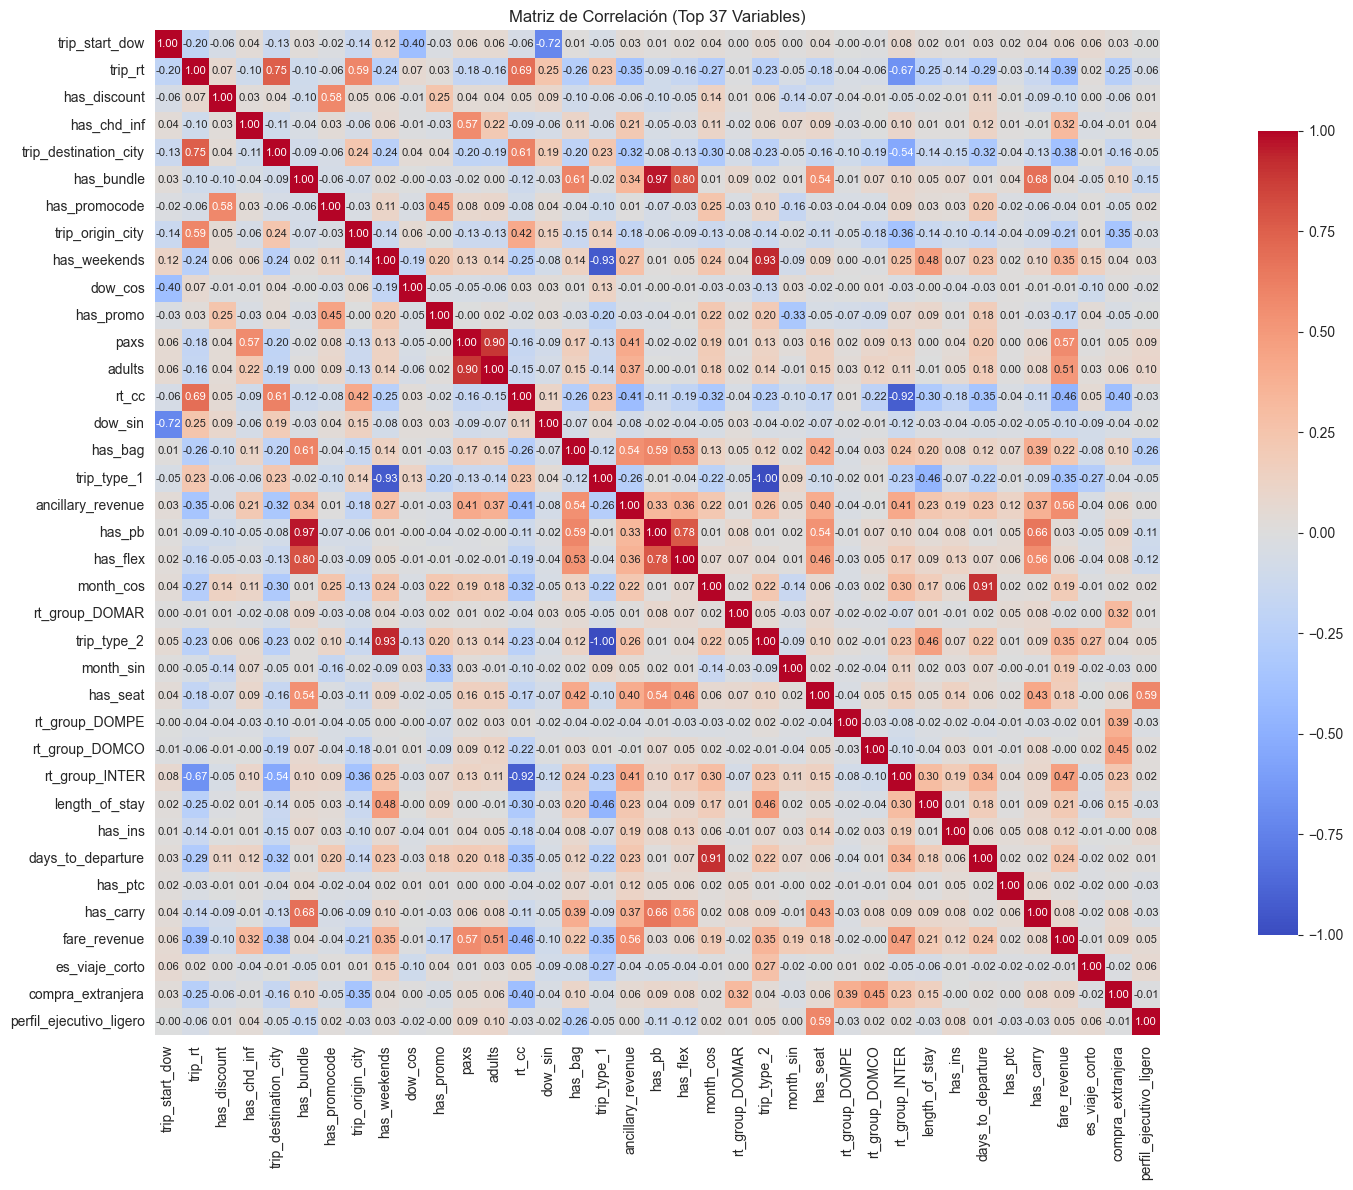

,trip_start_dow,trip_rt,has_discount,has_chd_inf,trip_destination_city,has_bundle,has_promocode,trip_origin_city,has_weekends,dow_cos,has_promo,paxs,adults,rt_cc,dow_sin,has_bag,trip_type_1,ancillary_revenue,has_pb,has_flex,month_cos,rt_group_DOMAR,trip_type_2,month_sin,has_seat,rt_group_DOMPE,rt_group_DOMCO,rt_group_INTER,length_of_stay,has_ins,days_to_departure,has_ptc,has_carry,fare_revenue,es_viaje_corto,compra_extranjera,perfil_ejecutivo_ligero
trip_start_dow,1.000000,-0.197882,-0.059729,0.035424,-0.129838,0.025023,-0.018637,-0.135996,0.122301,-0.397828,-0.027653,0.061478,0.056158,-0.059669,-0.719086,0.010171,-0.050796,0.031733,0.014187,0.023578,0.035916,0.000467,0.050796,0.003134,0.036907,-0.000974,-0.014420,0.075583,0.019182,0.013472,0.030247,0.017312,0.036512,0.059152,0.064277,0.025447,-0.000610
trip_rt,-0.197882,1.000000,0.070681,-0.103689,0.752300,-0.102954,-0.061607,0.591291,-0.242877,0.065786,0.026789,-0.177341,-0.164804,0.693267,0.249205,-0.259407,0.229255,-0.349334,-0.094444,-0.162062,-0.268873,-0.014707,-0.229255,-0.050811,-0.184810,-0.041924,-0.059206,-0.667569,-0.248616,-0.142894,-0.289438,-0.032765,-0.142197,-0.391396,0.021387,-0.253096,-0.055513
has_discount,-0.059729,0.070681,1.000000,0.030548,0.042684,-0.095640,0.584398,0.051155,0.060840,-0.008157,0.246812,0.041305,0.042209,0.048645,0.091582,-0.096547,-0.061092,-0.058127,-0.098280,-0.054863,0.135466,0.006130,0.061092,-0.141909,-0.072396,-0.035303,-0.006448,-0.051292,-0.017462,-0.006726,0.110224,-0.006614,-0.090069,-0.104817,0.000216,-0.057701,0.013203
has_chd_inf,0.035424,-0.103689,0.030548,1.000000,-0.106611,-0.044752,0.033178,-0.058293,0.063956,-0.013040,-0.034396,0.565608,0.216537,-0.094557,-0.063094,0.113690,-0.055515,0.211385,-0.048931,-0.028529,0.111806,-0.020835,0.055515,0.066717,0.085947,-0.028125,-0.003695,0.097065,0.009740,0.011344,0.119825,0.009920,-0.007573,0.316771,-0.035142,-0.008073,0.039307
trip_destination_city,-0.129838,0.752300,0.042684,-0.106611,1.000000,-0.087154,-0.056073,0.241716,-0.236346,0.044411,0.044566,-0.200181,-0.190678,0.612234,0.189154,-0.204673,0.228525,-0.322553,-0.084688,-0.133363,-0.301091,-0.077555,-0.228525,-0.049915,-0.161832,-0.095584,-0.188577,-0.543660,-0.143342,-0.152108,-0.319532,-0.037132,-0.130205,-0.377156,-0.007134,-0.158546,-0.052905
has_bundle,0.025023,-0.102954,-0.095640,-0.044752,-0.087154,1.000000,-0.063863,-0.072044,0.021064,-0.001491,-0.034252,-0.018544,0.000553,-0.116623,-0.032739,0.605981,-0.015569,0.339720,0.965956,0.797913,0.012706,0.085399,0.015569,0.012316,0.540042,-0.010458,0.072465,0.097103,0.047899,0.067524,0.011362,0.040011,0.682398,0.035932,-0.047441,0.102234,-0.152129
has_promocode,-0.018637,-0.061607,0.584398,0.033178,-0.056073,-0.063863,1.000000,-0.034559,0.110895,-0.031782,0.447034,0.082488,0.088782,-0.079484,0.035591,-0.039301,-0.103502,0.006991,-0.067121,-0.033301,0.245155,-0.025776,0.103502,-0.162374,-0.030758,-0.043716,-0.042112,0.087564,0.034047,0.030235,0.203148,-0.024766,-0.057700,-0.043760,0.010832,-0.052244,0.021447
trip_origin_city,-0.135996,0.591291,0.051155,-0.058293,0.241716,-0.072044,-0.034559,1.000000,-0.137267,0.059161,-0.002713,-0.129380,-0.125291,0.416777,0.147920,-0.145307,0.137764,-0.180725,-0.064188,-0.093416,-0.128638,-0.084733,-0.137764,-0.024815,-0.110300,-0.047720,-0.184571,-0.362789,-0.140097,-0.095383,-0.141258,-0.038191,-0.091660,-0.214175,0.008679,-0.347415,-0.034727
has_weekends,0.122301,-0.242877,0.060840,0.063956,-0.236346,0.021064,0.110895,-0.137267,1.000000,-0.186345,0.204189,0.133581,0.135860,-0.248228,-0.078159,0.136554,-0.933043,0.268709,0.011899,0.045585,0.238233,0.043516,0.933043,-0.093277,0.088462,0.003802,-0.013877,0.253941,0.480383,0.067376,0.234621,0.015139,0.099341,0.345232,0.151865,0.035977,0.025051
dow_cos,-0.397828,0.065786,-0.008157,-0.013040,0.044411,-0.001491,-0.031782,0.059161,-0.186345,1.000000,-0.045309,-0.052402,-0.056350,0.026509,0.028831,0.011728,0.132043,-0.011801,-0.001162,-0.013192,-0.034116,-0.029330,-0.132043,0.033403,-0.023177

In [10]:
matriz_correlacion(pack_rf_general, X_train)

In [11]:
# 2. Definir el Modelo (Decision Tree)
model_dt = DecisionTreeClassifier(
    max_depth=6,
    class_weight='balanced',
    criterion='gini',
    random_state=SEED
)

# 3. Entrenar
model_dt.fit(X_train, y_train)



# 5. Evaluar
y_pred_proba_dt = model_dt.predict_proba(X_test)[:, 1]
y_pred_final_dt = (y_pred_proba_dt > 0.6752).astype(int)

# 4. Calcular AUC
auc_score = roc_auc_score(y_test, y_pred_proba_dt)


print("Reporte del Árbol de Decisión:")
print(f"Área bajo la curva (AUC): {auc_score:.4f}")
print(classification_report(y_test, y_pred_final_dt))


Reporte del Árbol de Decisión:
Área bajo la curva (AUC): 0.8117
              precision    recall  f1-score   support

           0       0.78      0.87      0.82       596
           1       0.69      0.53      0.60       317

    accuracy                           0.75       913
   macro avg       0.73      0.70      0.71       913
weighted avg       0.75      0.75      0.74       913



In [12]:
def exportar_arbol_svg_simple(modelo, feature_names, profundidad=3, nombre_archivo="arbol_decision"):
    """
    Exporta el árbol a SVG usando solo Matplotlib (Sin instalar Graphviz).

    Args:
        modelo: Tu modelo entrenado (model_dt).
        feature_names: Lista de nombres de columnas.
        profundidad (int): Cuántos niveles mostrar.
        nombre_archivo (str): Nombre del archivo de salida.
    """
    # Ajustamos el tamaño del dibujo automáticamente según la profundidad
    # (Si es muy profundo, hacemos el lienzo más grande para que se lea)
    ancho = 250 + (profundidad * 2)
    alto = 100 + profundidad

    plt.figure(figsize=(ancho, alto))

    print(f"Dibujando árbol con profundidad {profundidad}...")

    plot_tree(
        modelo,
        feature_names=feature_names,
        class_names=['Ocio', 'Trabajo'], # Tus etiquetas
        filled=True,                     # Colores bonitos
        rounded=True,                    # Bordes suaves
        max_depth=profundidad,           # Control de niveles
        fontsize=10,                     # Tamaño de letra legible
        precision=2                      # Decimales a mostrar
    )

    # Aseguramos la extensión .svg
    if not nombre_archivo.endswith('.svg'):
        nombre_archivo += '.svg'

    # Guardamos usando Matplotlib
    plt.savefig(nombre_archivo, format='svg', bbox_inches='tight')
    plt.close() # Cerramos para liberar memoria

    print(f"¡Listo! Archivo guardado exitosamente: {nombre_archivo}")

# --- EJEMPLO DE USO ---
# Simplemente corre esto:
exportar_arbol_svg_simple(model_dt, X_train.columns, profundidad=6, nombre_archivo="Modelo_DT")

Dibujando árbol con profundidad 6...
¡Listo! Archivo guardado exitosamente: Modelo_DT.svg


In [13]:
def obtener_reglas_texto(modelo, feature_names):
    """
    Extrae las reglas del árbol en formato texto legible
    """
    reglas = export_text(modelo, feature_names=list(feature_names))
    print(reglas)

obtener_reglas_texto(model_dt, X_train.columns)

|--- trip_rt <= 0.34
|   |--- days_to_departure <= 17.50
|   |   |--- trip_destination_city <= 0.18
|   |   |   |--- fare_revenue <= 46.50
|   |   |   |   |--- ancillary_revenue <= 3.30
|   |   |   |   |   |--- days_to_departure <= 0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- days_to_departure >  0.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- ancillary_revenue >  3.30
|   |   |   |   |   |--- class: 0
|   |   |   |--- fare_revenue >  46.50
|   |   |   |   |--- has_bundle <= 0.50
|   |   |   |   |   |--- trip_destination_city <= 0.15
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- trip_destination_city >  0.15
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- has_bundle >  0.50
|   |   |   |   |   |--- trip_destination_city <= 0.14
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- trip_destination_city >  0.14
|   |   |   |   |   |   |--- class: 0
|   |   |--- trip_destination_city >  0.18
|   |   |   |--- has_